# QBUS2820 Assignment 1

**SID:** 510575452

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import ggplot
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.regressionplots import plot_ceres_residuals
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize, Normalizer, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, f_regression, SequentialFeatureSelector
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Loading in Dataset

In [241]:
heating_load_training_data = pd.read_csv('data/HeatingLoad_training.csv')
heating_load_test_without_HL_data = pd.read_csv(
    'data/HeatingLoad_test_without_HL.csv')

# EDA

## Looking at key characteristics of the dataset

In [242]:
heating_load_training_data.head()

,BuildingAge,BuildingHeight,Insulation,AverageTemperature,SunlightExposure,WindSpeed,OccupancyRate,HeatingLoad
0,18.56,30.36,1,13.75,453.67,3.89,0.65,275.89
1,13.82,9.64,0,18.70,138.85,0.95,0.55,208.02
2,36.47,8.44,1,18.23,190.31,4.71,0.56,234.86
3,23.23,18.71,1,21.89,313.15,8.51,0.25,243.89
4,11.62,11.95,0,19.49,117.53,1.57,0.58,205.94


In [243]:
heating_load_training_data.columns

Index(['BuildingAge', 'BuildingHeight', 'Insulation', 'AverageTemperature',
       'SunlightExposure', 'WindSpeed', 'OccupancyRate', 'HeatingLoad'],
      dtype='object')

In [244]:
heating_load_training_data.shape

(10000, 8)

## Data Cleaning

### Removing null values

In [245]:
# drop nan values
heating_load_training_data = heating_load_training_data.dropna()


## Looking at the information of the dataset

In [246]:
heating_load_training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BuildingAge         10000 non-null  float64
 1   BuildingHeight      10000 non-null  float64
 2   Insulation          10000 non-null  int64  
 3   AverageTemperature  10000 non-null  float64
 4   SunlightExposure    10000 non-null  float64
 5   WindSpeed           10000 non-null  float64
 6   OccupancyRate       10000 non-null  float64
 7   HeatingLoad         10000 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 625.1 KB


## Looking at the description of the dataset

In [247]:
heating_load_training_data.describe()

,BuildingAge,BuildingHeight,Insulation,AverageTemperature,SunlightExposure,WindSpeed,OccupancyRate,HeatingLoad
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,22.765466,20.792105,0.596000,18.024851,271.361610,4.490681,0.500124,260.078634
std,12.385964,16.882672,0.490722,4.090699,229.275176,2.531248,0.221971,74.591892
min,2.990000,3.070000,0.000000,1.680000,1.150000,0.070000,0.010000,173.680000
25%,14.250000,9.310000,0.000000,15.270000,100.082500,2.610000,0.330000,218.087500
50%,20.090000,15.020000,1.000000,18.020000,182.435000,4.100000,0.500000,236.800000
75%,28.092500,25.830000,1.000000,20.810000,407.090000,5.960000,0.670000,270.350000
max,153.880000,106.360000,1.000000,34.340000,1250.710000,18.910000,1.000000,793.920000


## Checking for null values

In [248]:
heating_load_training_data.isnull().sum()

BuildingAge           0
BuildingHeight        0
Insulation            0
AverageTemperature    0
SunlightExposure      0
WindSpeed             0
OccupancyRate         0
HeatingLoad           0
dtype: int64

## Check how each of the variables interact with each other

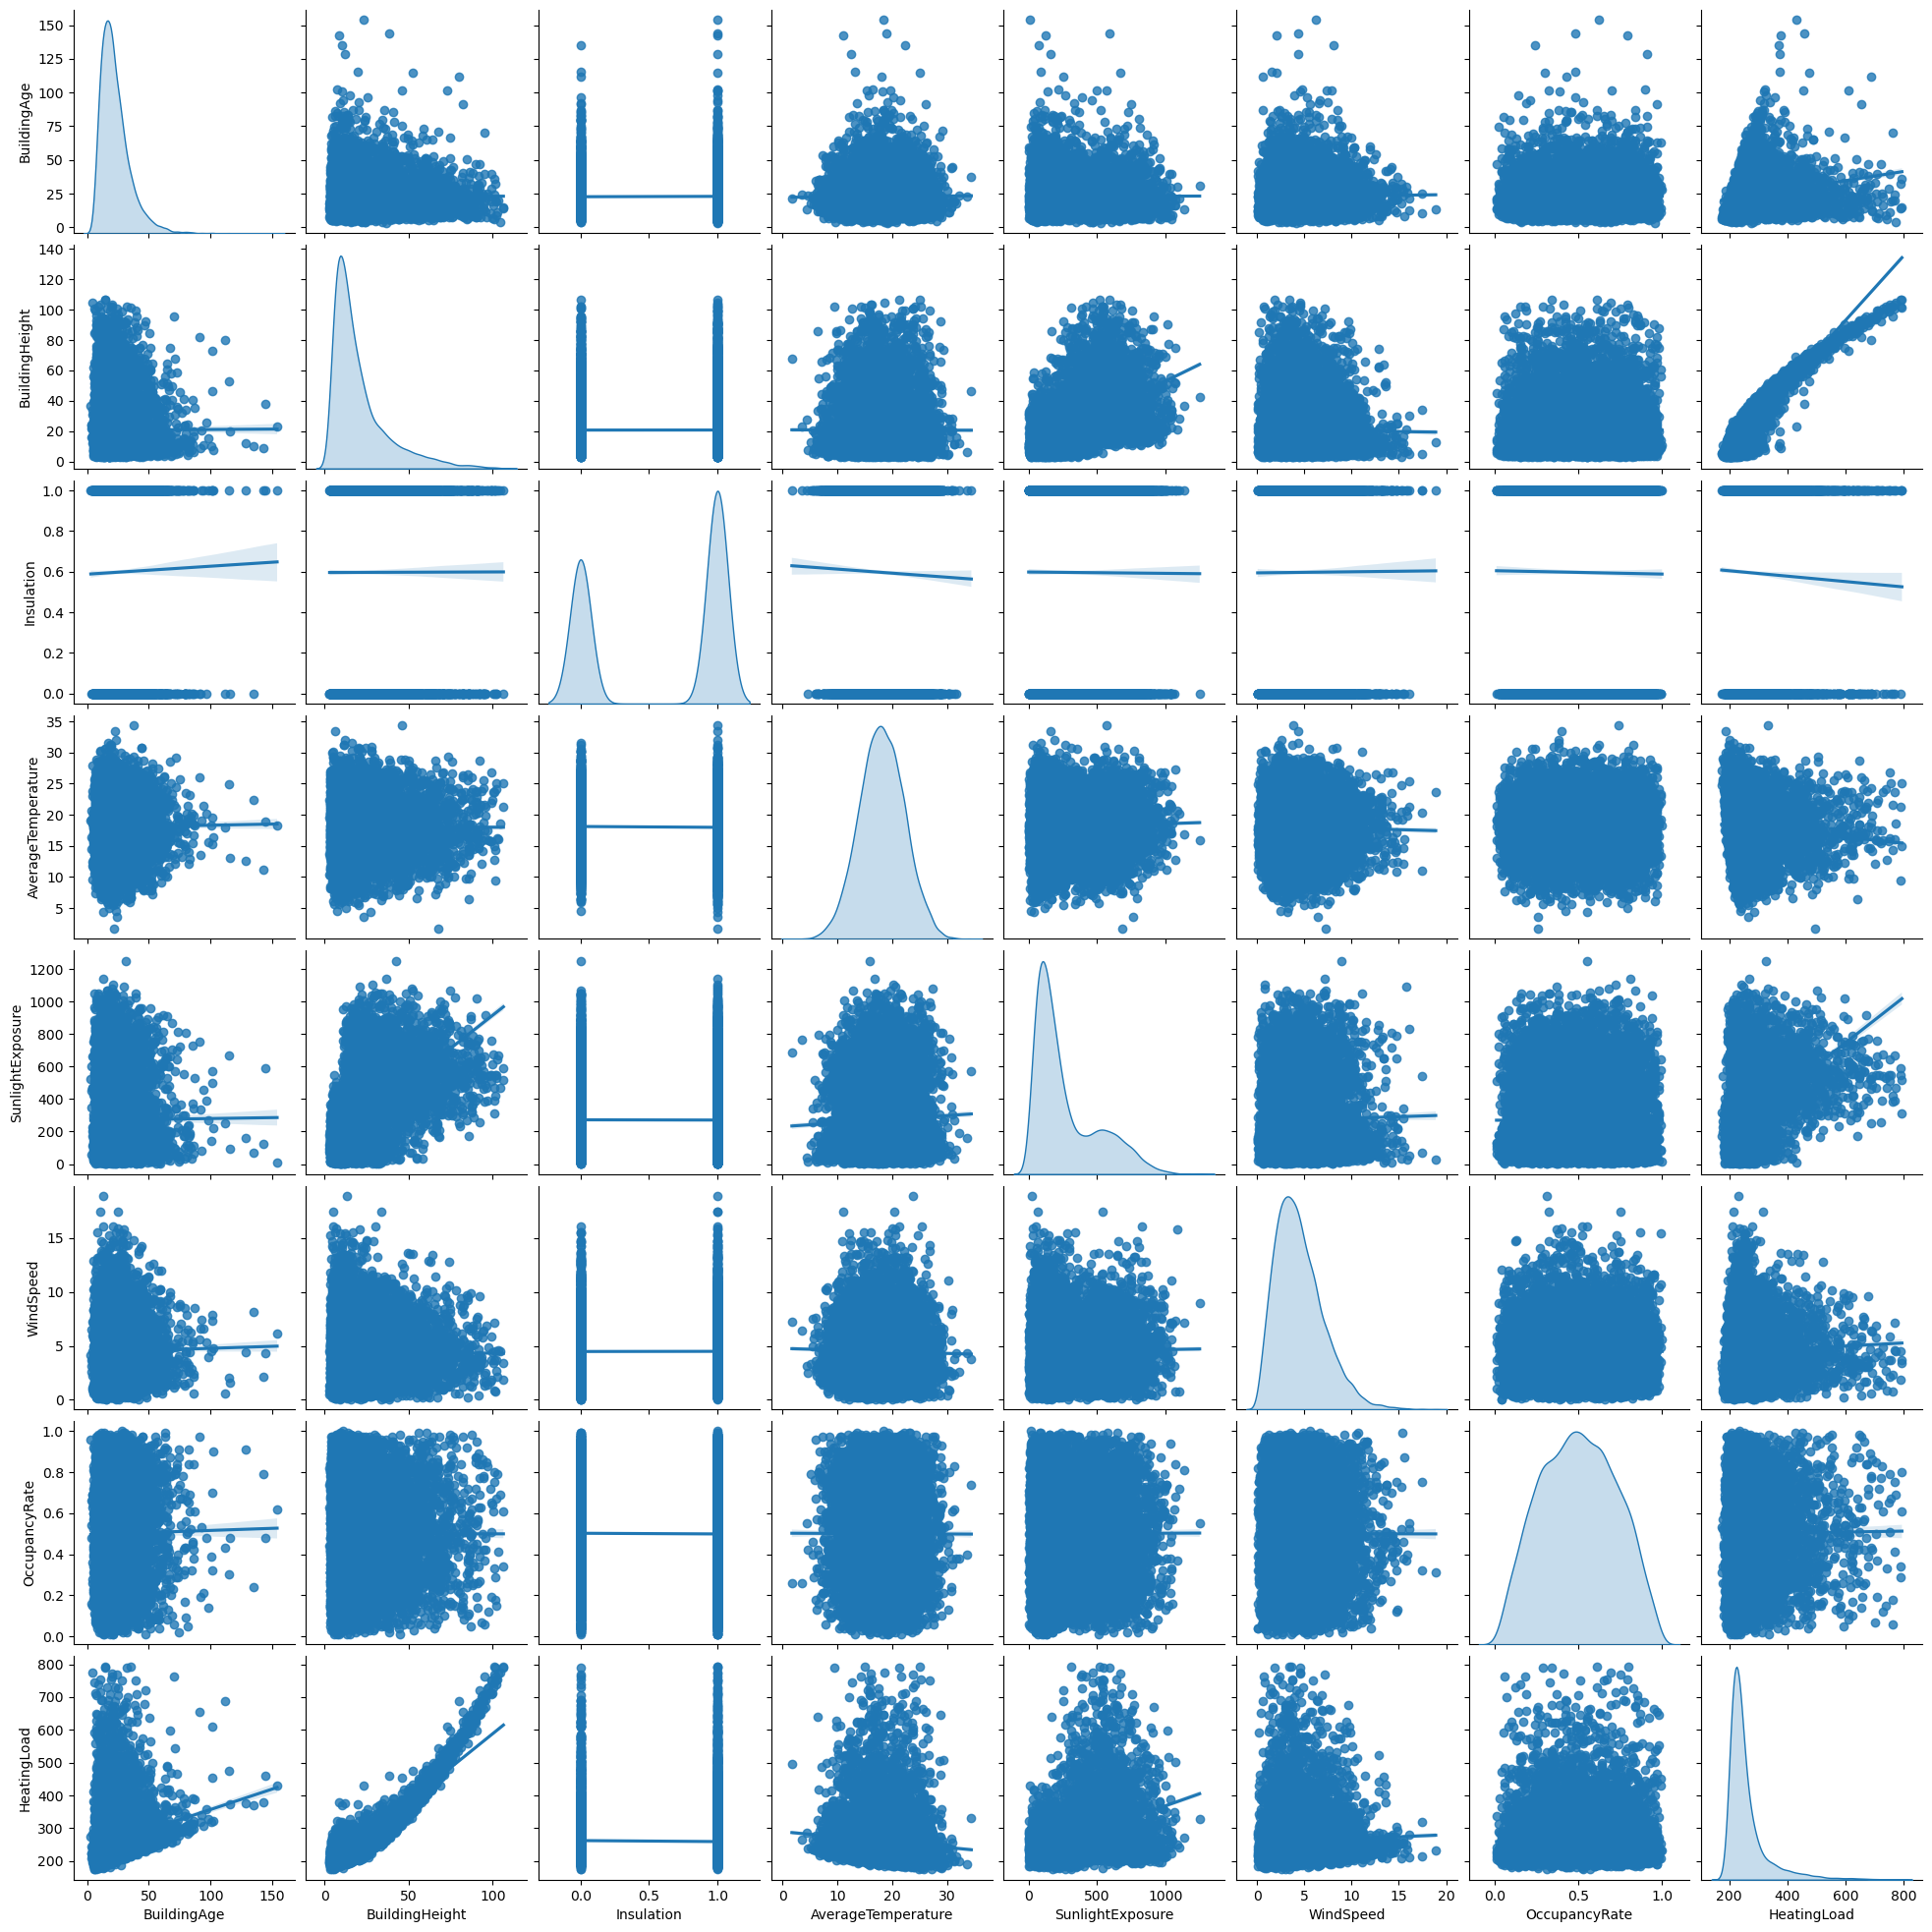

In [249]:
sns.pairplot(heating_load_training_data, kind='reg', diag_kind='kde')

## Checking for skewness

### Histogram

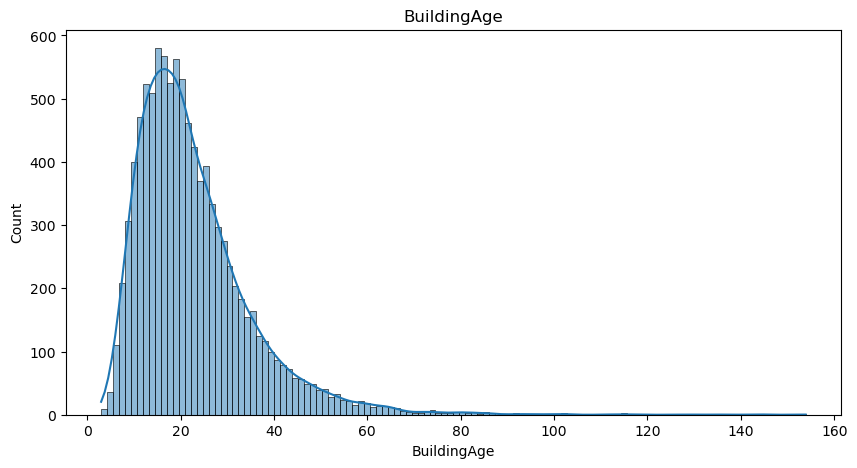

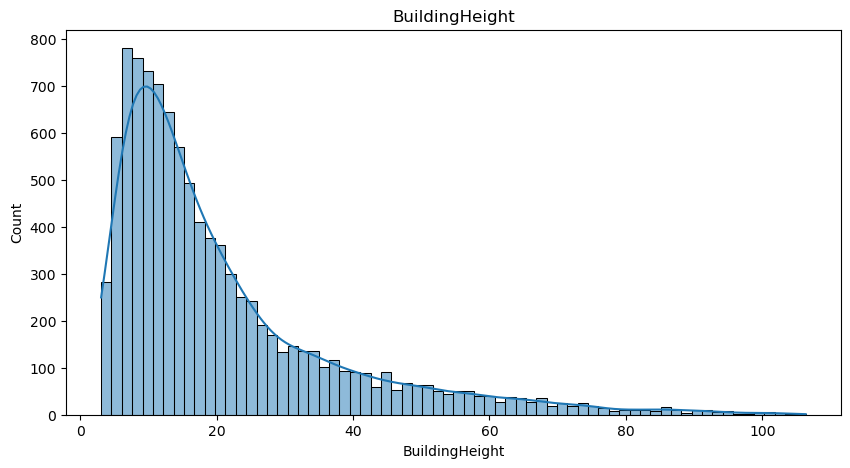

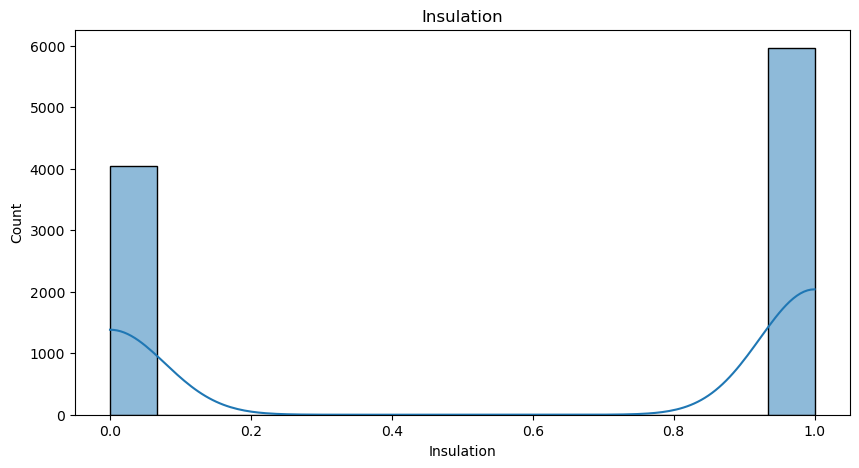

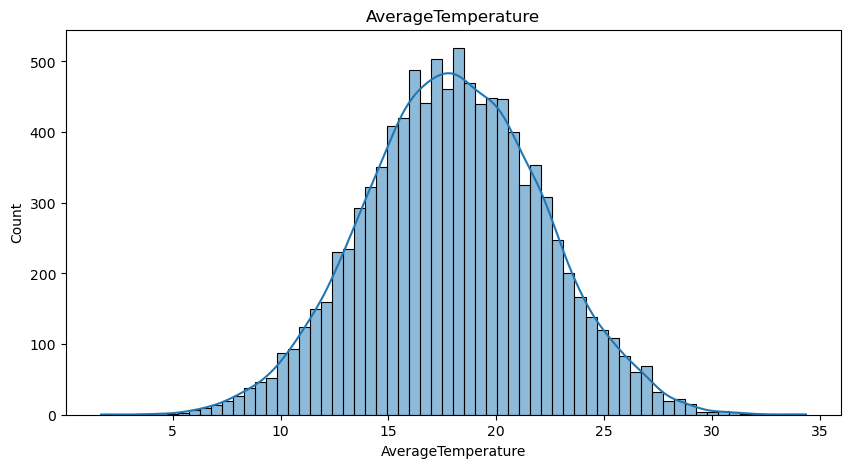

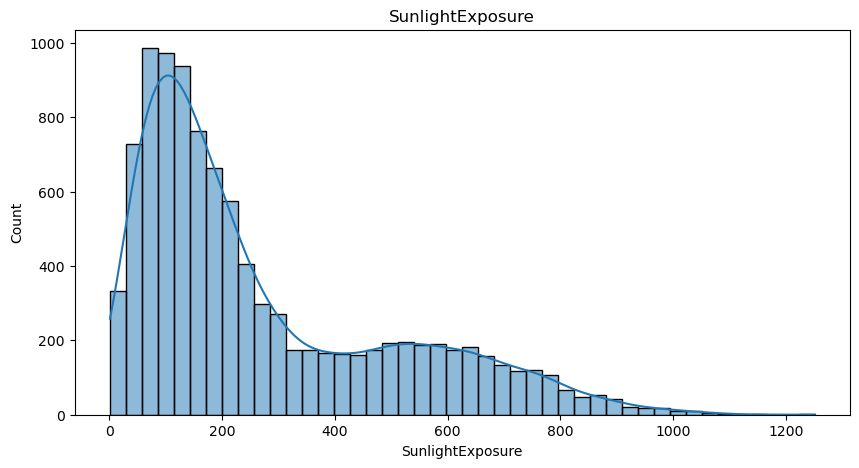

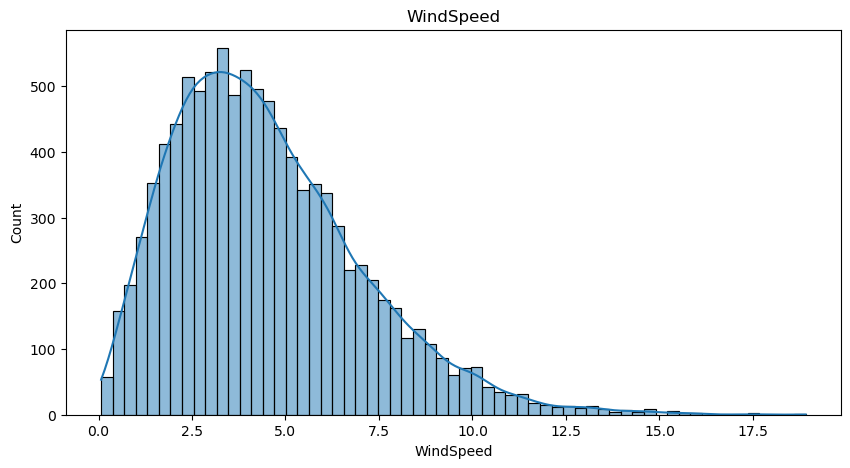

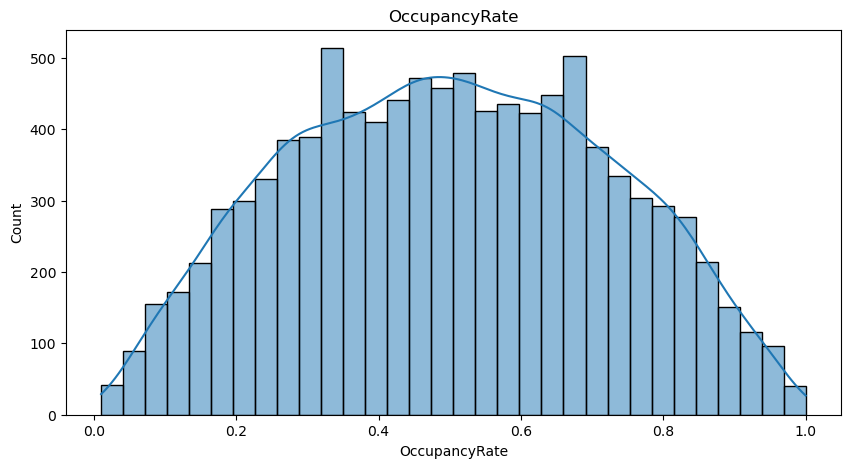

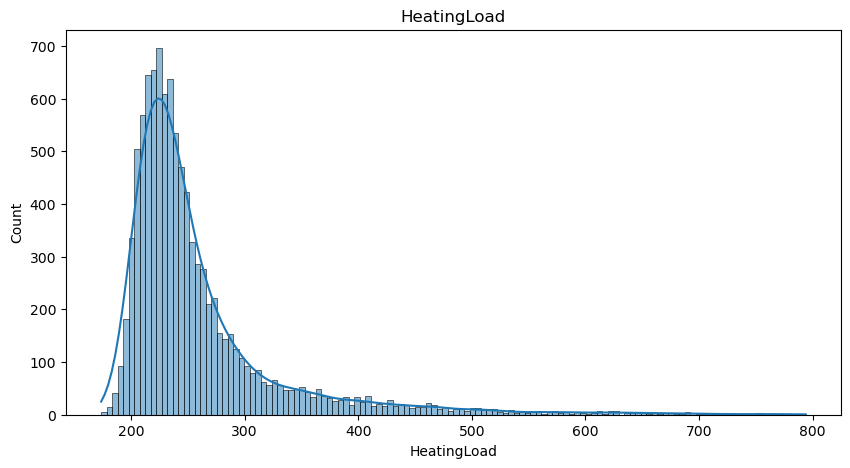

In [250]:
# Create a histogram of the variables with bell shaped distribution
for i in heating_load_training_data.columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(heating_load_training_data[i], kde=True)
    plt.title(i)
    plt.show()

### QQ-plot

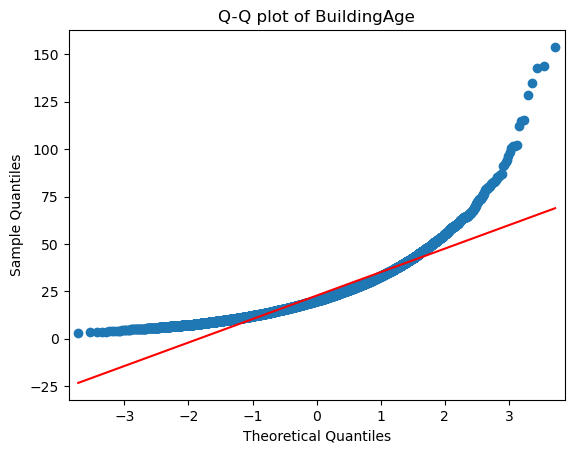

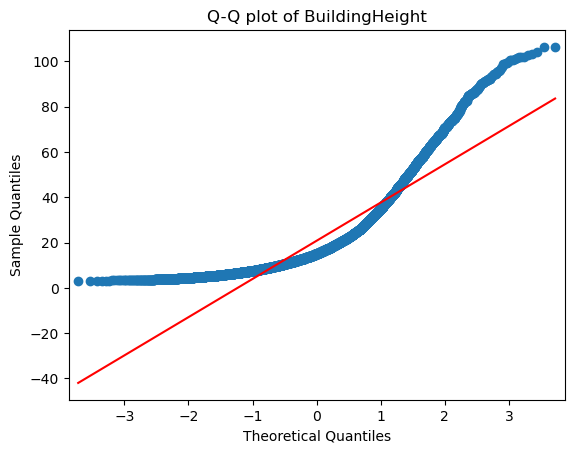

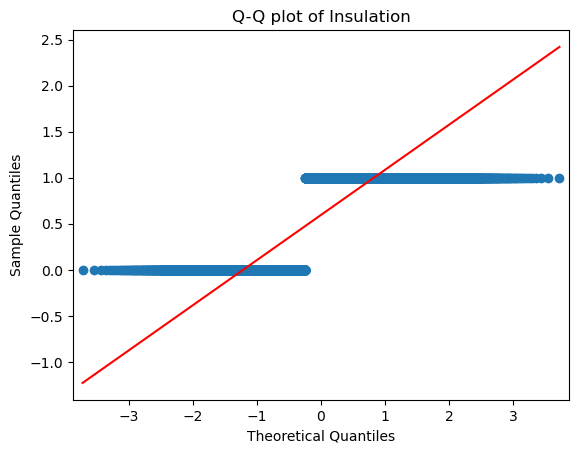

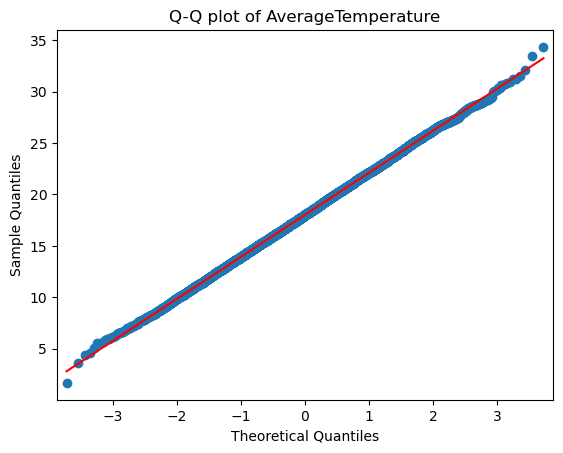

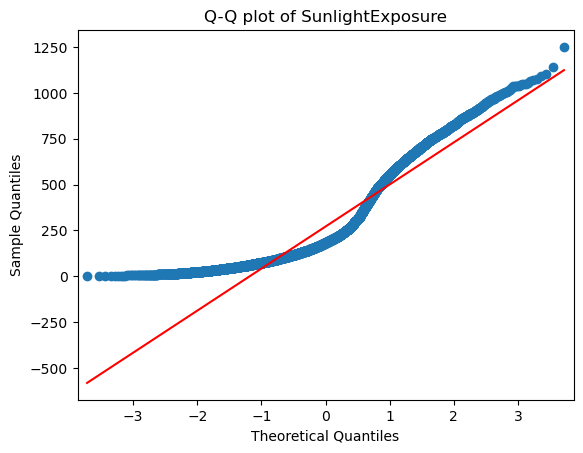

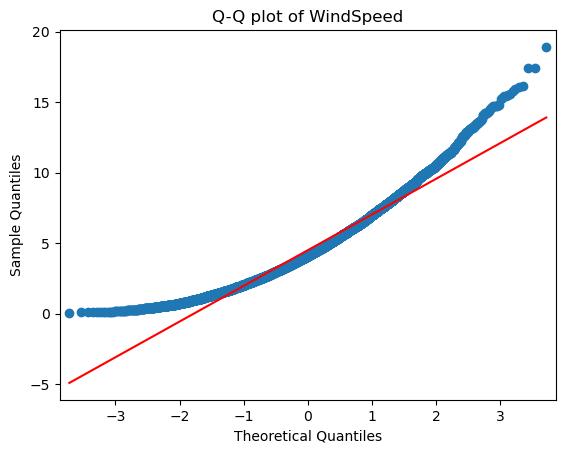

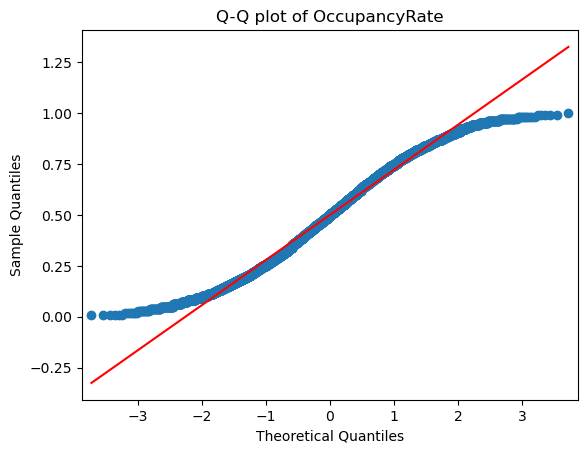

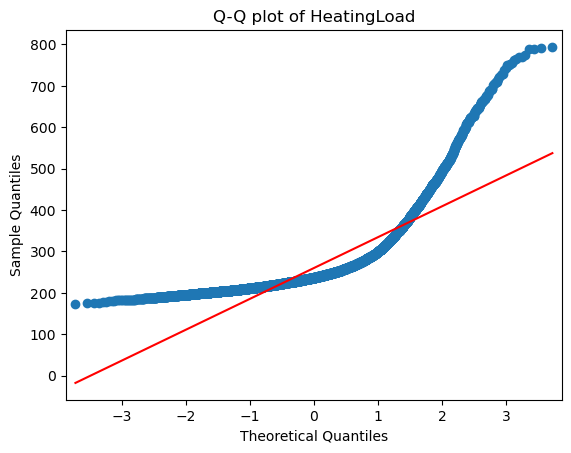

In [207]:
for i in heating_load_training_data.columns:
    sm.qqplot(heating_load_training_data[i], line='s')
    plt.title(f'Q-Q plot of {i}')
    plt.show()

# Correlation Analysis

In [251]:
correlations_heating_load_training_data = heating_load_training_data.corr()

## Correlation Heatmap

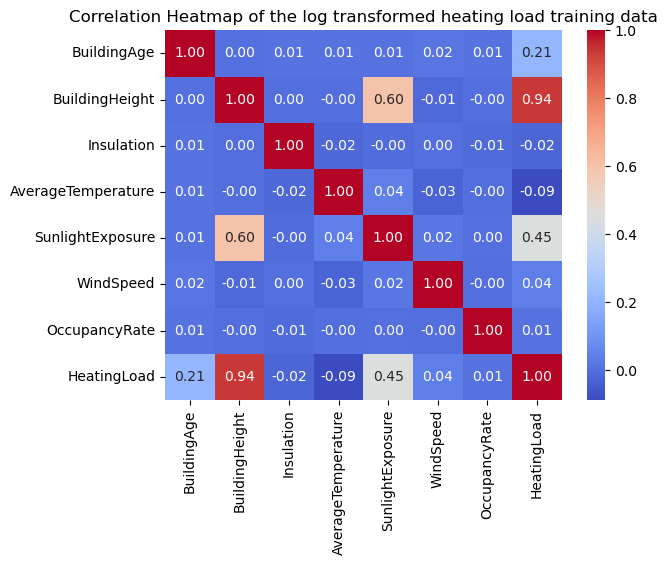

In [252]:
sns.heatmap(correlations_heating_load_training_data, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of the log transformed heating load training data')
plt.show()

# Model Development

## Full Data training and validation splits

In [253]:
X = heating_load_training_data.drop('HeatingLoad', axis=1)
y = heating_load_training_data['HeatingLoad']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2820)

In [287]:
kfold = KFold(n_splits=10, shuffle=True, random_state=2820)

## Linear Regression

In [302]:
linear_regression = LinearRegression()
sfs_linear_regression = SequentialFeatureSelector_linear_regression = SFS(
    linear_regression, k_features='best', forward=True, floating=False, scoring='neg_mean_squared_error', cv=kfold, verbose=2)
sfs_linear_regression.fit(X_train, y_train)


[2024-09-21 23:33:28] Features: 1/7 -- score: -664.5002134607855
[2024-09-21 23:33:28] Features: 2/7 -- score: -435.9953264622712
[2024-09-21 23:33:28] Features: 3/7 -- score: -338.41345121780057
[2024-09-21 23:33:28] Features: 4/7 -- score: -302.0177265136214
[2024-09-21 23:33:29] Features: 5/7 -- score: -284.8701664222082
[2024-09-21 23:33:29] Features: 6/7 -- score: -281.29793261774734
[2024-09-21 23:33:29] Features: 7/7 -- score: -280.9889204882428

SequentialFeatureSelector(cv=KFold(n_splits=10, random_state=2820, shuffle=True),
                          estimator=LinearRegression(), k_features=(1, 7),
                          scoring='neg_mean_squared_error', verbose=2)

In [316]:
feat_names_linear_regression = list(sfs_linear_regression.k_feature_names_)
print(feat_names_linear_regression)

print(sfs_linear_regression.k_feature_idx_)

['BuildingAge', 'BuildingHeight', 'Insulation', 'AverageTemperature', 'SunlightExposure', 'WindSpeed', 'OccupancyRate']
(0, 1, 2, 3, 4, 5, 6)


In [317]:
sfs_linear_regression.k_score_

-280.9889204882428

In [318]:
selected_feature_indices_linear_regression = list(sfs_linear_regression.k_feature_idx_)
selected_feature_names_linear_regression = [
    feat_names_linear_regression[i] for i in selected_feature_indices_linear_regression]
print("Selected features:", selected_feature_names_linear_regression)

Selected features: ['BuildingAge', 'BuildingHeight', 'Insulation', 'AverageTemperature', 'SunlightExposure', 'WindSpeed', 'OccupancyRate']


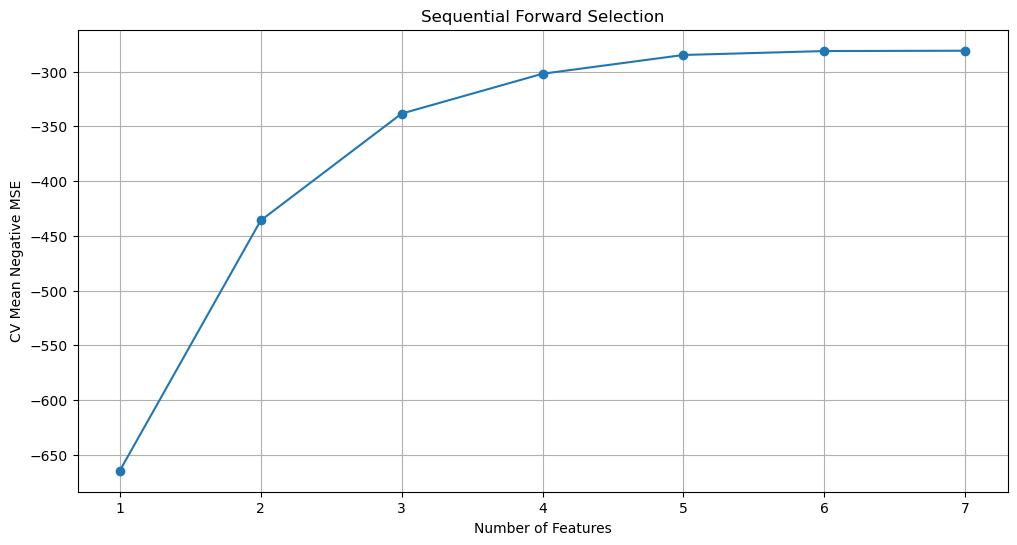

In [319]:
metric_dict = sfs_linear_regression.get_metric_dict()
k_features = [len(k['feature_idx']) for k in metric_dict.values()]
cv_scores = [k['cv_scores'].mean() for k in metric_dict.values()]

plt.figure(figsize=(12, 6))
plt.plot(k_features, cv_scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('CV Mean Negative MSE')
plt.title('Sequential Forward Selection')
plt.grid()
plt.show()

In [320]:
X_optimal_linear_regression = X[selected_feature_names_linear_regression]
X_optimal_linear_regression.head()
linear_regression_OLS = sm.OLS(y, X_optimal_linear_regression).fit()
linear_regression_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            HeatingLoad   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                          9.195e+04
Date:                Sat, 21 Sep 2024   Prob (F-statistic):                        0.00
Time:                        23:43:59   Log-Likelihood:                         -49291.
No. Observations:               10000   AIC:                                  9.860e+04
Df Residuals:                    9993   BIC:                                  9.865e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
BuildingAge            1.9053      0.026     73.591      0.000       1.855       1.956
BuildingHeight         4.8863      0.025    199.346      0.000       4.838       4.934
Insulation             8.8661      0.666     13.310      0.000       7.560      10.172
AverageTemperature     3.8115      0.055     69.901      0.000       3.705       3.918
SunlightExposure      -0.0471      0.002    -25.840      0.000      -0.051      -0.044
WindSpeed              5.1935      0.126     41.298      0.000       4.947       5.440
OccupancyRate         51.4702      1.395     36.887      0.000      48.735      54.205
==============================================================================
Omnibus:                       41.429   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.375
Skew:                           0.050   Prob(JB):                     1.56e-12
Kurtosis:                       3.347   Cond. No.                     1.49e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

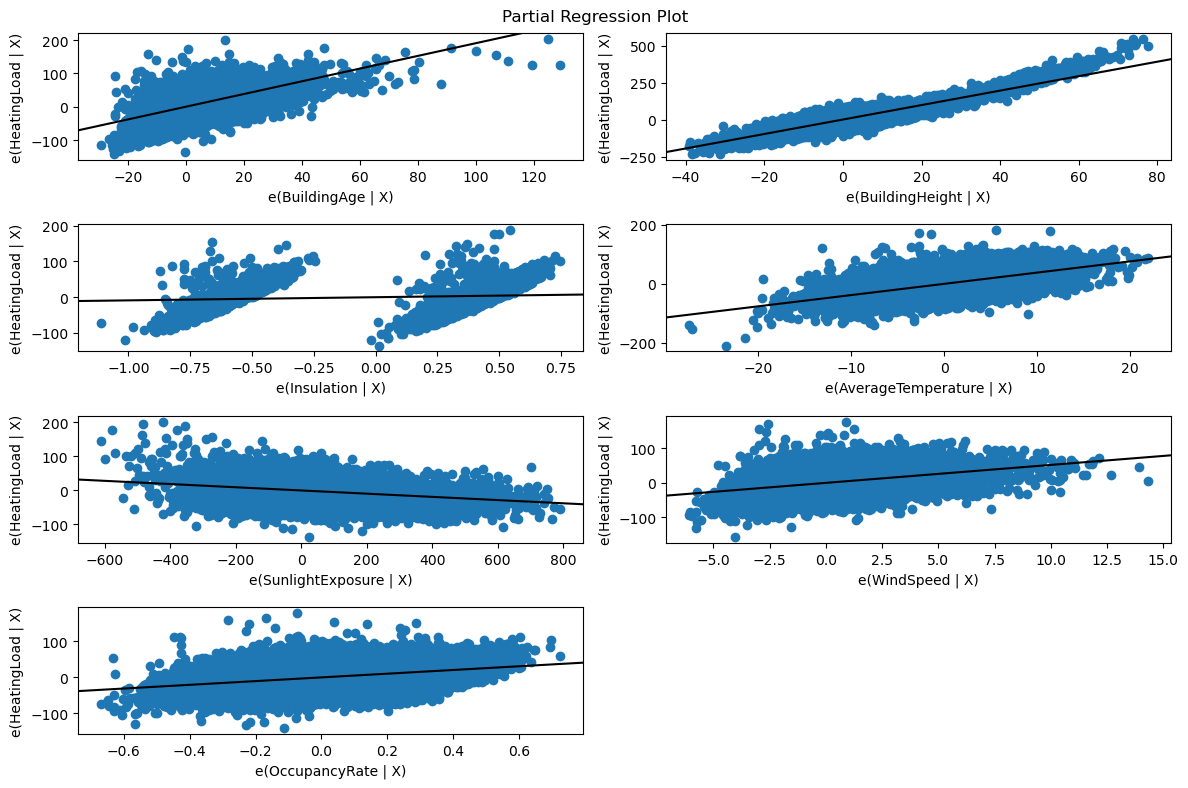

In [321]:
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.plot_partregress_grid(linear_regression_OLS, fig=fig)

### Residual Plot Analysis

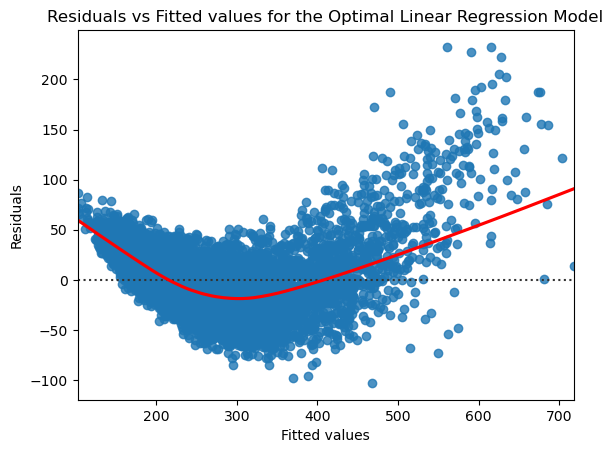

In [358]:
linear_regression_residuals = heating_load_training_data.copy()

linear_regression_residuals['y_hat'] = linear_regression_OLS.fittedvalues.copy(
)
linear_regression_residuals['residuals'] = linear_regression_residuals['HeatingLoad'] - \
    linear_regression_residuals['y_hat']

sns.residplot(data=linear_regression_residuals, x='y_hat',
              y='residuals', lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted values for the Optimal Linear Regression Model')
plt.show()

In [324]:
optimised_linear_regression = linear_regression.fit(
    X_train[selected_feature_names_linear_regression], y_train)

y_pred = optimised_linear_regression.predict(
    X_val[selected_feature_names_linear_regression])
mse = mean_squared_error(y_val, y_pred)
print("Validation Mean Squared Error:", mse)

Validation Mean Squared Error: 311.30001835188324


## KNN

In [325]:
# linear_regression = LinearRegression()
# kfold = KFold(n_splits=10, shuffle=True, random_state=2820)
# sfs_linear_regression = SequentialFeatureSelector_linear_regression = SFS(
#     linear_regression, k_features='best', forward=True, floating=False, scoring='neg_mean_squared_error', cv=kfold, verbose=2)
# SequentialFeatureSelector_linear_regression.fit(X_train, y_train)

knn_regression = KNeighborsRegressor()
sfs_knn_regression = SFS(knn_regression, k_features='best', forward=True, floating=False,
                         scoring='neg_mean_squared_error', cv=kfold, verbose=2)
sfs_knn_regression.fit(X_train, y_train)


[2024-09-21 23:44:43] Features: 1/7 -- score: -408.19325548300003
[2024-09-21 23:44:43] Features: 2/7 -- score: -125.54721667999998
[2024-09-21 23:44:43] Features: 3/7 -- score: -79.7674130065
[2024-09-21 23:44:43] Features: 4/7 -- score: -64.0002662295
[2024-09-21 23:44:43] Features: 5/7 -- score: -62.774563968500004
[2024-09-21 23:44:43] Features: 6/7 -- score: -62.6948716415
[2024-09-21 23:44:44] Features: 7/7 -- score: -218.56672251499998

SequentialFeatureSelector(cv=KFold(n_splits=10, random_state=2820, shuffle=True),
                          estimator=KNeighborsRegressor(), k_features=(1, 7),
                          scoring='neg_mean_squared_error', verbose=2)

In [327]:
feat_names_knn_regression = list(sfs_knn_regression.k_feature_names_)
print(feat_names_knn_regression)
print(sfs_knn_regression.k_feature_idx_)

['BuildingAge', 'BuildingHeight', 'Insulation', 'AverageTemperature', 'WindSpeed', 'OccupancyRate']
(0, 1, 2, 3, 5, 6)


In [329]:
sfs_knn_regression.k_score_

-62.6948716415

In [352]:
selected_feature_indices_knn_regression = list(sfs_knn_regression.k_feature_idx_)

selected_feature_names_knn_regression = []
for i in feat_names_knn_regression:
    if i == 3:
        pass
    selected_feature_names_knn_regression.append(i)
print("Selected features:", selected_feature_names_knn_regression)

Selected features: ['BuildingAge', 'BuildingHeight', 'Insulation', 'AverageTemperature', 'WindSpeed', 'OccupancyRate']


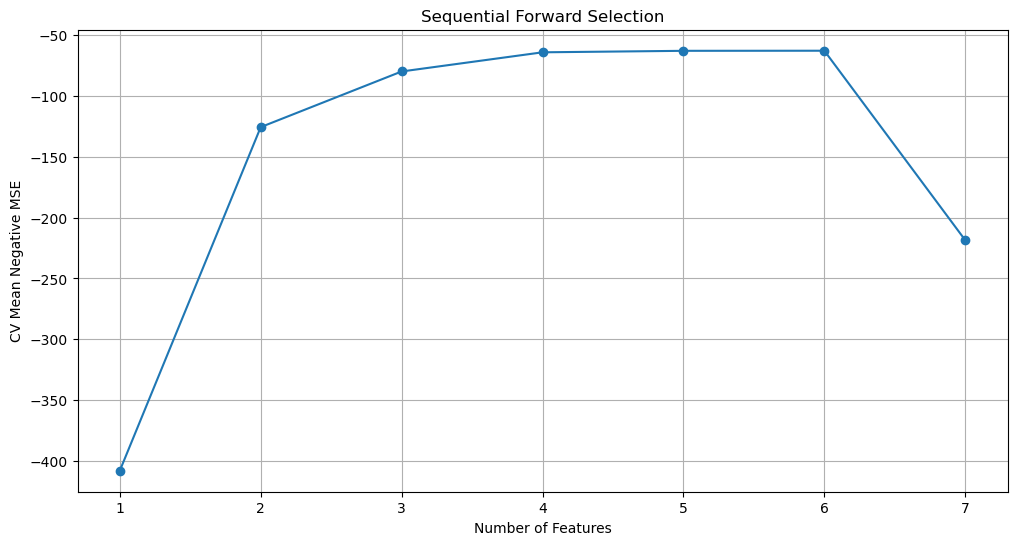

In [353]:
metric_dict = sfs_knn_regression.get_metric_dict()
k_features = [len(k['feature_idx']) for k in metric_dict.values()]
cv_scores = [k['cv_scores'].mean() for k in metric_dict.values()]

plt.figure(figsize=(12, 6))
plt.plot(k_features, cv_scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('CV Mean Negative MSE')
plt.title('Sequential Forward Selection')
plt.grid()
plt.show()

In [355]:
X_optimal_knn_regression = X[selected_feature_names_knn_regression]
X_optimal_knn_regression.head()
knn_regression_OLS = sm.OLS(y, X_optimal_knn_regression).fit()
knn_regression_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            HeatingLoad   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                          1.005e+05
Date:                Sun, 22 Sep 2024   Prob (F-statistic):                        0.00
Time:                        00:38:59   Log-Likelihood:                         -49615.
No. Observations:               10000   AIC:                                  9.924e+04
Df Residuals:                    9994   BIC:                                  9.928e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
BuildingAge            1.8944      0.027     70.856      0.000       1.842       1.947
BuildingHeight         4.4983      0.020    224.803      0.000       4.459       4.538
Insulation             8.7752      0.688     12.756      0.000       7.427      10.124
AverageTemperature     3.6345      0.056     65.053      0.000       3.525       3.744
WindSpeed              5.0195      0.130     38.701      0.000       4.765       5.274
OccupancyRate         50.6840      1.441     35.178      0.000      47.860      53.508
==============================================================================
Omnibus:                      103.971   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.922
Skew:                           0.068   Prob(JB):                     3.44e-37
Kurtosis:                       3.620   Cond. No.                         160.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

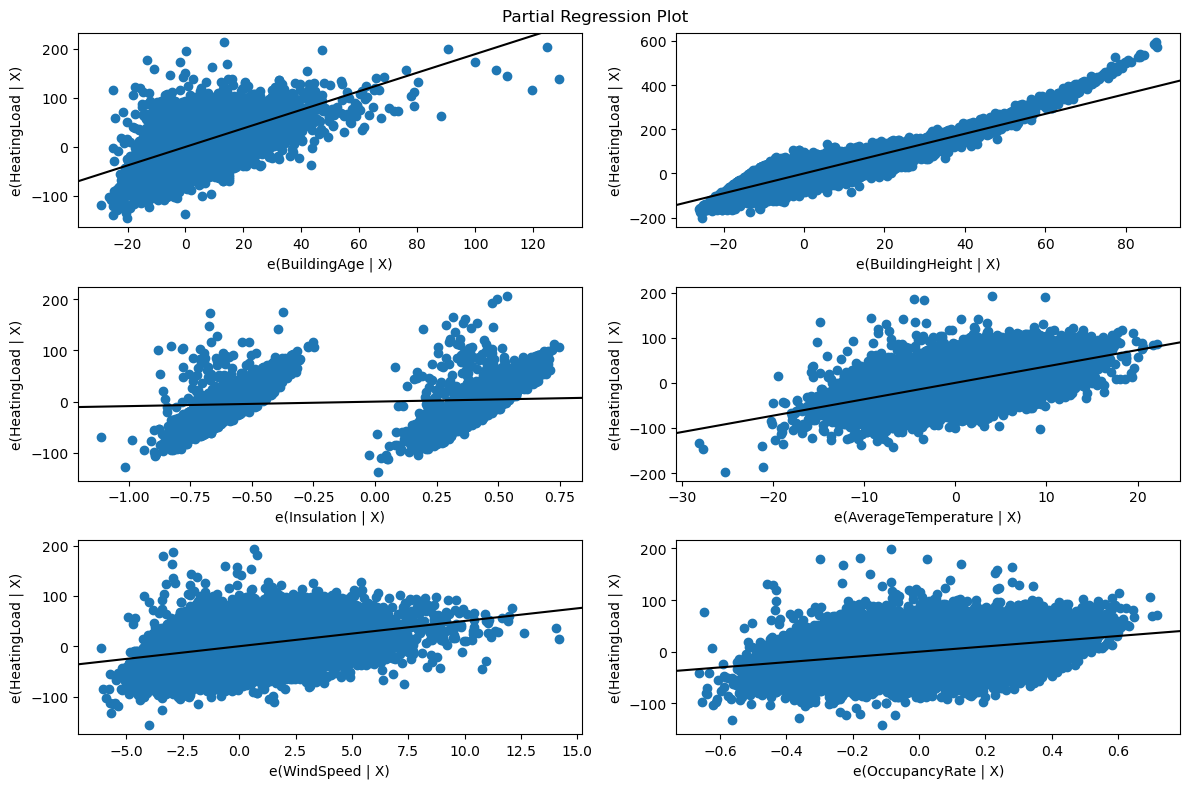

In [356]:
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.plot_partregress_grid(knn_regression_OLS, fig=fig)

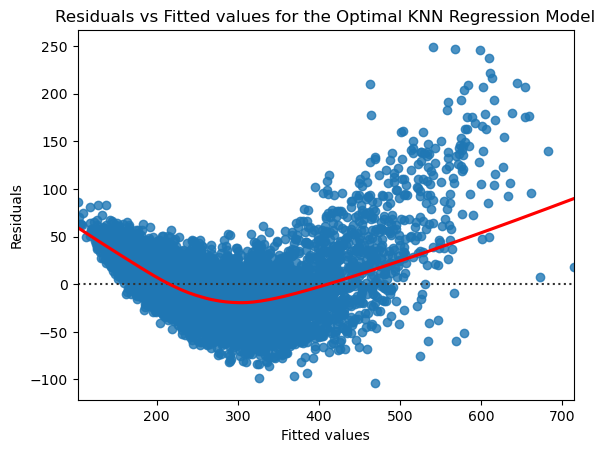

In [359]:
knn_regression_residuals = heating_load_training_data.copy()

knn_regression_residuals['y_hat'] = knn_regression_OLS.fittedvalues.copy()
knn_regression_residuals['residuals'] = knn_regression_residuals['HeatingLoad'] - knn_regression_residuals['y_hat']

sns.residplot(data=knn_regression_residuals, x='y_hat',
                y='residuals', lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted values for the Optimal KNN Regression Model')
plt.show()

In [360]:
optimised_knn_regression = knn_regression.fit(
    X_train[selected_feature_names_knn_regression], y_train)

y_pred = optimised_knn_regression.predict(
    X_val[selected_feature_names_knn_regression])
mse = mean_squared_error(y_val, y_pred)
print("Validation Mean Squared Error:", mse)

Validation Mean Squared Error: 60.224851188000024


In [381]:
heating_load_test_without_HL_data = heating_load_test_without_HL_data.dropna()

heating_load_test_without_HL_data_predictions = np.round(optimised_knn_regression.predict(
    heating_load_test_without_HL_data[selected_feature_names_knn_regression]), 4)

heating_load_test_without_HL_data_predictions = pd.DataFrame(
    heating_load_test_without_HL_data_predictions, columns=['HeatingLoad'])

print(heating_load_test_without_HL_data_predictions)

      HeatingLoad
0         234.694
1         205.152
2         320.132
3         242.142
4         195.456
...           ...
4939      202.816
4940      280.616
4941      278.976
4942      274.860
4943      289.038

[4944 rows x 1 columns]


# Saving Predictions of best Regression Model

In [382]:
prediction = pd.DataFrame(heating_load_test_without_HL_data_predictions, columns=[
                          'HeatingLoad']).to_csv('510575452_Assignment_HL_prediction.csv')
prediction

# Code Chunk to run tests on unseen dataset

In [ ]:
HeatingLoad_test = pd.read_csv("HeatingLoad_test.csv")

test_error = mean_squared_error(HeatingLoad_test['HeatingLoad'], heating_load_test_without_HL_data_predictions)

print(test_error)